In [1]:
from train_model_nonlinear import *

['/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils']


In [2]:
config_path = '/home/shiqi/code/Project2-sensor-case/model_combination_Argos/pca_from_formulation/output_hybrid/experiment_1/config.yaml'
config = read_config_file(config_path)

In [3]:
save_dir = config['save_dir']

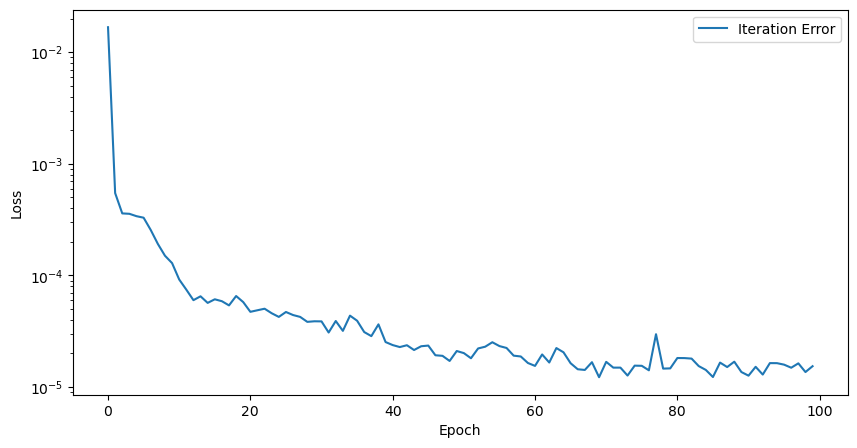

In [4]:
iteration_errors = np.load(os.path.join(save_dir, 'iteration_errors.npy'))

import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(iteration_errors, label='Iteration Error')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [5]:
import torch
import os
import numpy as np
import copy
import pca_koopman_dir as km
from train_model_nonlinear import build_model, SimpleNN, ResidualModel, LinearModel, data_preparation

def initialize_models(config, save_dir):
    # Build the pre-trained model
    pre_trained_model = build_model(config)
    
    # Data preparation
    x_data, y_data, u_data = data_preparation(config, config['fit_data_dir'])
    x_data = torch.tensor(x_data, dtype=torch.float32)
    y_data = torch.tensor(y_data, dtype=torch.float32)
    u_data = torch.tensor(u_data, dtype=torch.float32)
    
    # Compute mean and standard deviation, and create standardization layers
    x_mean = torch.mean(x_data, dim=0)
    x_std = torch.std(x_data, dim=0)
    std_layer_x = km.StdScalerLayer(x_mean, x_std)
    
    u_mean = torch.mean(u_data, dim=0)
    u_std = torch.std(u_data, dim=0)
    std_layer_u = km.StdScalerLayer(u_mean, u_std)
    
    # Load the state dictionary for the linear model
    linear_model_state_dict = torch.load(os.path.join(save_dir, 'linear_model.pth'))
    linear_model = LinearModel(pre_trained_model, std_layer_x, np.zeros(3))
    linear_model.load_state_dict(linear_model_state_dict)
    linear_model.eval()
    
    # Initialize the residual model
    n_features = x_data.shape[1]
    n_inputs = u_data.shape[1]
    residual_NN = SimpleNN(n_features + n_inputs, config['NN_nodes_num'], n_features, config['num_hidden_layers'])
    residual_model = ResidualModel(residual_NN, std_layer_x, std_layer_u, copy.deepcopy(std_layer_x))
    
    # Load the state dictionary for the residual model
    residual_model_state_dict = torch.load(os.path.join(save_dir, 'residual_model.pth'))
    residual_model.load_state_dict(residual_model_state_dict)
    
    return linear_model, residual_model

In [6]:
linear_model, residual_model = initialize_models(config, save_dir)

0
1
2
window_size: 150
(149, 6957) (149, 6957) (149, 2)
x_data shape: (6258, 6957), y_data shape: (6258, 6957), u_data shape: (6258, 2)


In [7]:
linear_model.eval()
residual_model.eval()

ResidualModel(
  (model): SimpleNN(
    (hidden_layers): ModuleList()
    (input_layer): Linear(in_features=6959, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=6957, bias=True)
  )
  (std_layer_x): StdScalerLayer()
  (std_layer_u): StdScalerLayer()
  (std_layer_err): StdScalerLayer()
)

In [8]:
import sys
device = torch.device('cpu')
sys.path.append('/home/shiqi/code/Project2-sensor-case/model_combination_Argos/utils')
x_data, y_data, u_data = data_preparation(config, config['fit_data_dir'])
x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
y_data = torch.tensor(y_data, dtype=torch.float32).to(device)
u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
data_loader, err_data = prepare_data_residual(x_data, y_data, u_data, linear_model, device)

window_size: 150
(149, 6957) (149, 6957) (149, 2)
x_data shape: (6258, 6957), y_data shape: (6258, 6957), u_data shape: (6258, 2)


In [9]:
loss_1 = 0

for x, y, u in data_loader:
    x = x.to(device)
    y = y.to(device)
    u = u.to(device)
    x_pred = residual_model(x, u)
    loss = torch.nn.functional.mse_loss(x_pred, y)
    loss_1 += loss.item()
loss_1 = loss_1 / len(data_loader)
    

In [10]:
print(loss_1)

0.0002078579875939925


In [18]:
x_data_slices = cut_slides(x_data, config['window_size'] - 1, 2)
y_data_slices = cut_slides(y_data, config['window_size'] - 1, 2)
u_data_slices = cut_slides(u_data, config['window_size'] - 1, 2)
x_data_slices = torch.cat(x_data_slices, dim=0)
y_data_slices = torch.cat(y_data_slices, dim=0)
u_data_slices = torch.cat(u_data_slices, dim=0)

In [19]:
print(x_data_slices.shape)

torch.Size([6216, 2, 6957])


In [20]:
print(x_data.shape)

torch.Size([6258, 6957])


In [24]:
data_loader_2, _ = prepare_data_residual(x_data_slices, y_data_slices, u_data_slices, None, device)


In [25]:
loss_2 = 0

def loss_fn(linear_model, residual_model, x_data, u_data):
    mse = nn.MSELoss()
    N = x_data.shape[1]
    if N <= 1:
        raise ValueError('Number of time steps should be greater than 1')
    
    # print(N)
    x0 = x_data[:, 0, :]
    x_pred = torch.zeros_like(x_data)
    x_pred[:, 0, :] = x0
    
    if residual_model is not None:
        for i in range(1, N):
            x_pred_cur = linear_model(x_pred[:, i-1, :], u_data[:, i-1, :]) + residual_model(x_pred[:, i-1, :], u_data[:, i-1, :])
            x_pred[:, i, :] = x_pred_cur

    else:
        for i in range(1, N):
            x_pred_cur = linear_model(x_pred[:, i-1, :], u_data[:, i-1, :])
            x_pred[:, i, :] = x_pred_cur


    loss =  mse(x_pred, x_data)
    return loss
    

for x, _, u in data_loader_2:
    x = x.to(device)
    u = u.to(device)
    loss = loss_fn(linear_model, residual_model, x, u)
    loss_2 += loss.item()
loss_2 = loss_2 / len(data_loader_2)
print(loss_2)

0.00010950834569354941
